In [ ]:
# ONLY run these 3 blocks (above imports) in Google Colab

# Uncomment the following two lines every runtime
# !pip uninstall gensim
# !pip install gensim

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Make sure using GPU throught "Edit-Notebook settings"
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

In [3]:
from gensim.models import Word2Vec
import pandas as pd
import matplotlib as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
import re
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

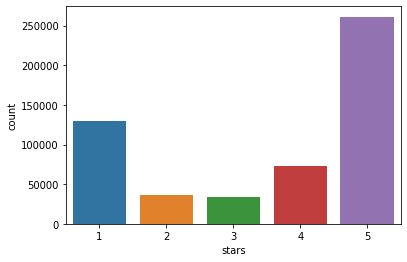

In [5]:
# Google Colab
# yelp = pd.read_json('/content/drive/MyDrive/cs182_proj/yelp_review_training_dataset.jsonl', lines=True)
# Locally
yelp = pd.read_json('./yelp_review_training_dataset.jsonl', lines=True)
yelp.head()
stars = yelp['stars'].values
ax = sns.countplot(x="stars",data=yelp)

In [6]:
yelp.shape

(533581, 3)

In [7]:
yelp[yelp.stars.notnull()]

review_id  \
0       Q1sbwvVQXV2734tPgoKj4Q   
1       GJXCdrto3ASJOqKeVWPi6Q   
2       2TzJjDVDEuAW6MR5Vuc1ug   
3       yi0R0Ugj_xUx_Nek0-_Qig   
4       11a8sVPMUFtaC7_ABRkmtw   
...                        ...   
533576  2vQO_kmSr6YPBrR8GH_FPA   
533577  DUdLTGVpgsi0sv_g4A5ITQ   
533578  AKGELpRNTTXajuZHbPxdJg   
533579  ghYZM7lqzjej05I_T3vYyA   
533580  gupUBwWRb13IvQhlKd6wdg   

                                                     text  stars  
0       Total bill for this horrible service? Over $8G...      1  
1       I *adore* Travis at the Hard Rock's new Kelly ...      5  
2       I have to say that this office really has it t...      5  
3       Went in for a lunch. Steak sandwich was delici...      5  
4       Today was my second out of three sessions I ha...      1  
...                                                   ...    ...  
533576  Dr Young and her assistants take obvious pride...      5  
533577  We started our 20 month of daughter here on an...      5  
533578  First of all, they are supposed to open at 9:0...      2  
533579  It's not often that you visit a company and th...      5  
533580  We had great experience with quest limos this ...      5  

[533581 rows x 3 columns]

In [8]:
x_train = yelp['text'].values
x_train[0]

'Total bill for this horrible service? Over $8Gs. These crooks actually had the nerve to charge us $69 for 3 pills. I checked online the pills can be had for 19 cents EACH! Avoid Hospital ERs at all costs.'

In [10]:
symbol = r'\w+|[^\s\w]+'
res = re.findall( symbol, x_train[0])
res[0]

'Total'

In [11]:
training = [re.findall( symbol, i) for i in x_train]
training = np.array(training)

/Users/will/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [12]:
training = list(training)
first_part = round(len(training) * 0.2)
print(first_part)

106716


In [13]:
self_model = Word2Vec(training[:first_part], min_count=1)
training_sample = [[self_model.wv.key_to_index[word] for word in sentence] for sentence in training[:first_part]]
self_model.wv.index_to_key[0]

'.'

In [14]:
y = np.array(stars[:first_part])
training_sample = np.array(training_sample)
train_x, val_x, train_y, val_y = train_test_split(training_sample, y, test_size=0.3, random_state=42)

/Users/will/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [15]:
maxlen = 200
train_x = keras.preprocessing.sequence.pad_sequences(train_x, maxlen=maxlen)
val_x = keras.preprocessing.sequence.pad_sequences(val_x, maxlen=maxlen)

In [16]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.15):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.norm1 = layers.LayerNormalization(epsilon=1e-7)
        self.norm2 = layers.LayerNormalization(epsilon=1e-7)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        att1 = self.att(inputs, inputs)
        out1 = self.dropout1(att1, training=training)
        out1 = self.norm1(inputs + att1)
        out2 = self.ffn(out1)
        out2 = self.dropout2(out2, training=training)
        return self.norm2(out1 + out2)

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions
    
# Adjust these to improve accuracies
embed_dim = 32  # Embedding size for each token
num_heads = 4  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer
vocab_size = 200000

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)

transformer_block1 = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block1(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.15)(x)
x = layers.Dense(ff_dim, activation="relu")(x)
x = layers.Dropout(0.15)(x)

outputs = layers.Dense(6, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [17]:
model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])
history = model.fit(
    train_x, train_y, batch_size=32, epochs=5, validation_data=(val_x, val_y)
)

Epoch 1/5
2335/2335 [==============================] - 577s 246ms/step - loss: 0.9421 - accuracy: 0.6485 - val_loss: 0.6635 - val_accuracy: 0.7397
Epoch 2/5
2335/2335 [==============================] - 601s 258ms/step - loss: 0.5807 - accuracy: 0.7747 - val_loss: 0.6780 - val_accuracy: 0.7357
Epoch 3/5
2335/2335 [==============================] - 561s 240ms/step - loss: 0.4960 - accuracy: 0.8070 - val_loss: 0.7672 - val_accuracy: 0.7295
Epoch 4/5
2335/2335 [==============================] - 571s 244ms/step - loss: 0.3937 - accuracy: 0.8498 - val_loss: 0.8462 - val_accuracy: 0.7202
Epoch 5/5
2335/2335 [==============================] - 569s 244ms/step - loss: 0.3119 - accuracy: 0.8834 - val_loss: 1.0487 - val_accuracy: 0.7078


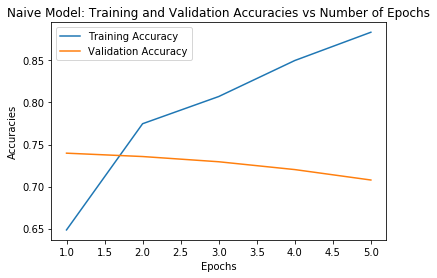

In [10]:
import matplotlib.pyplot as plt
epochs = [1, 2, 3, 4, 5]
ta = [0.6485, 0.7747, 0.8070, 0.8498, 0.8834]
va = [0.7397, 0.7357, 0.7295, 0.7202, 0.7078]
plt.plot(epochs, ta, label="Training Accuracy")
plt.plot(epochs, va, label="Validation Accuracy")
plt.title("Naive Model: Training and Validation Accuracies vs Number of Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracies")
plt.legend()